<h1 align='center'> Impact of HbA1c Measurement on Hospital Readmission Rates </h1>
<h4 align='center'> Analysis of 70,000 Clinical Database Patient Records </h4> 

## 0. Import relevant Dependencies

Incase you are getting any error saying the package is not installed while running the below cell, then you can use two methods:
- pip install ________.
- google 'How to install ________'.

In [1]:
# Import Dependencies -To see the graphs in the notebook.
%matplotlib inline   

# Python Imports
import math,time,random,datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization -This is where the graphs come in.
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Objective

In this Jupyter Notepad, we will using the 130-US hospitals Dataset to predict whether an individual will be readmitted based on the diabetes data.

The dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

Also this is the article which gave a detailed explanation: https://www.hindawi.com/journals/bmri/2014/781670/

## 2. Loading the required Data

> We have previously converted our diabetes dataset into the .csv format and kept it in the folder called "MODEL DATA"

In [2]:
# Import the dataset for our model.
df = pd.read_csv('MODEL DATA/EDA_diabetes.csv')

In [3]:
# Viewing the dataset
pd.set_option('display.max_columns', None)
df.head()

,Readmitted,Pmo,Race,Sex,Age,Admission_ID,Discharged_ID,Time_in_Hospital,Procedures,Medications,Diagnosis,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone
0,Y,55629189.0,Caucasian,1,[10-20),1,1,"(0.987, 3.6]",59,18,250.0,None,None,1,1,No,No,No,No,No,No,No,No,Up,No,No,No
1,N,86047875.0,AfricanAmerican,1,[20-30),1,1,"(0.987, 3.6]",11,13,250.0,None,None,0,1,No,No,No,No,No,No,No,No,No,No,No,No
2,N,82442376.0,Caucasian,0,[30-40),1,1,"(0.987, 3.6]",44,16,250.0,None,None,1,1,No,No,No,No,No,No,No,No,Up,No,No,No
3,N,42519267.0,Caucasian,0,[40-50),1,1,"(0.987, 3.6]",51,8,250.0,None,None,1,1,No,No,No,No,No,No,No,No,Steady,No,No,No
4,Y,82637451.0,Caucasian,0,[50-60),2,1,"(0.987, 3.6]",31,16,250.0,None,None,0,1,No,No,No,No,No,No,No,No,Steady,No,No,No


In [4]:
# Removing the diagnosis column.
df = df.drop('Diagnosis', axis= 1)
df = df.drop('Admission_ID', axis= 1)
df = df.drop('Discharged_ID', axis= 1)
df.head(3)

,Readmitted,Pmo,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone
0,Y,55629189.0,Caucasian,1,[10-20),"(0.987, 3.6]",59,18,None,None,1,1,No,No,No,No,No,No,No,No,Up,No,No,No
1,N,86047875.0,AfricanAmerican,1,[20-30),"(0.987, 3.6]",11,13,None,None,0,1,No,No,No,No,No,No,No,No,No,No,No,No
2,N,82442376.0,Caucasian,0,[30-40),"(0.987, 3.6]",44,16,None,None,1,1,No,No,No,No,No,No,No,No,Up,No,No,No


In [5]:
print("Dimensionality of the dataset: ", df.shape)

Dimensionality of the dataset:  (24169, 24)


In [6]:
# These are the relevent columns that we have chosen in our Exploratory Data Analysis.
df.columns

Index(['Readmitted', 'Pmo', 'Race', 'Sex', 'Age', 'Time_in_Hospital',
       'Procedures', 'Medications', 'Glu_result', 'A1C_result', 'Change',
       'Diabetes_Med', 'metformin', 'repaglinide', 'nateglinide',
       'glimepiride', 'glyburide', 'pioglitazone', 'rosiglitazone', 'miglitol',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'metformin-pioglitazone'],
      dtype='object')

## 3. Feature Encoding

**Remember that Machine Learning algorithms perform Linear Algebra on Matrices, which means all features need to have numeric ** **values. The process of converting Categorical Features into values is called Encoding. Let's perform both <i> "One-Hot Encoding" and "Label Encoding".</i>**


Additional Resources: http://pbpython.com/categorical-encoding.html

In [7]:
# One Hot Encoded df_dis variables
one_hot_cols = df.columns.tolist()
one_hot_cols.remove('Readmitted')                             # --> Here we remove Readmitted because we dont need encode this.
one_hot_cols.remove('Pmo')                                    # --> Here we remove Pmo because we dont need encode this.
df_dis_enc = pd.get_dummies(df, columns= one_hot_cols)

df_dis_enc.head()

,Readmitted,Pmo,Race_AfricanAmerican,Race_Asian,Race_Caucasian,Race_Hispanic,Race_Other,Sex_0,Sex_1,Age_[0-10),Age_[10-20),Age_[20-30),Age_[30-40),Age_[40-50),Age_[50-60),Age_[60-70),Age_[70-80),Age_[80-90),Age_[90-100),"Time_in_Hospital_(0.987, 3.6]","Time_in_Hospital_(11.4, 14.0]","Time_in_Hospital_(3.6, 6.2]","Time_in_Hospital_(6.2, 8.8]","Time_in_Hospital_(8.8, 11.4]",Procedures_1,Procedures_2,Procedures_3,Procedures_4,Procedures_5,Procedures_6,Procedures_7,Procedures_8,Procedures_9,Procedures_10,Procedures_11,Procedures_12,Procedures_13,Procedures_14,Procedures_15,Procedures_16,Procedures_17,Procedures_18,Procedures_19,Procedures_20,Procedures_21,Procedures_22,Procedures_23,Procedures_24,Procedures_25,Procedures_26,Procedures_27,Procedures_28,Procedures_29,Procedures_30,Procedures_31,Procedures_32,Procedures_33,Procedures_34,Procedures_35,Procedures_36,Procedures_37,Procedures_38,Procedures_39,Procedures_40,Procedures_41,Procedures_42,Procedures_43,Procedures_44,Procedures_45,Procedures_46,Procedures_47,Procedures_48,Procedures_49,Procedures_50,Procedures_51,Procedures_52,Procedures_53,Procedures_54,Procedures_55,Procedures_56,Procedures_57,Procedures_58,Procedures_59,Procedures_60,Procedures_61,Procedures_62,Procedures_63,Procedures_64,Procedures_65,Procedures_66,Procedures_67,Procedures_68,Procedures_69,Procedures_70,Procedures_71,Procedures_72,Procedures_73,Procedures_74,Procedures_75,Procedures_76,Procedures_77,Procedures_78,Procedures_79,Procedures_80,Procedures_81,Procedures_82,Procedures_83,Procedures_84,Procedures_85,Procedures_86,Procedures_87,Procedures_88,Procedures_89,Procedures_90,Procedures_91,Procedures_92,Procedures_93,Procedures_94,Procedures_95,Procedures_96,Procedures_97,Procedures_98,Procedures_99,Procedures_101,Procedures_102,Procedures_103,Procedures_105,Procedures_106,Procedures_107,Procedures_108,Procedures_111,Procedures_113,Procedures_118,Medications_1,Medications_2,Medications_3,Medications_4,Medications_5,Medications_6,Medications_7,Medications_8,Medications_9,Medications_10,Medications_11,Medications_12,Medications_13,Medications_14,Medications_15,Medications_16,Medications_17,Medications_18,Medications_19,Medications_20,Medications_21,Medications_22,Medications_23,Medications_24,Medications_25,Medications_26,Medications_27,Medications_28,Medications_29,Medications_30,Medications_31,Medications_32,Medications_33,Medications_34,Medications_35,Medications_36,Medications_37,Medications_38,Medications_39,Medications_40,Medications_41,Medications_42,Medications_43,Medications_44,Medications_45,Medications_46,Medications_47,Medications_48,Medications_49,Medications_50,Medications_51,Medications_52,Medications_53,Medications_54,Medications_55,Medications_56,Medications_57,Medications_58,Medications_59,Medications_60,Medications_61,Medications_62,Medications_66,Medications_67,Glu_result_>200,Glu_result_>300,Glu_result_None,Glu_result_Norm,A1C_result_>7,A1C_result_>8,A1C_result_None,A1C_result_Norm,Change_0,Change_1,Diabetes_Med_0,Diabetes_Med_1,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_Down,nateglinide_No,nateglinide_Steady,nateglinide_Up,glimepiride_Down,glimepiride_No,glimepiride_Steady,glimepiride_Up,glyburide_Down,glyburide_No,glyburide_Steady,glyburide_Up,pioglitazone_Down,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_Down,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,miglitol_No,miglitol_Steady,miglitol_Up,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady
0,Y,55629189.0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [8]:
# Label Encoded using LabelEncoder()
df_con_enc = df.apply(LabelEncoder().fit_transform)
df_con_enc = df_con_enc.drop('Pmo', axis= 1)
df_con_enc['Pmo'] = df['Pmo']
df_con_enc.head(6)

,Readmitted,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone,Pmo
0,1,2,1,1,0,58,17,2,2,1,1,1,1,1,1,1,1,1,0,3,1,0,0,55629189.0
1,0,0,1,2,0,10,12,2,2,0,1,1,1,1,1,1,1,1,0,1,1,0,0,86047875.0
2,0,2,0,3,0,43,15,2,2,1,1,1,1,1,1,1,1,1,0,3,1,0,0,82442376.0
3,0,2,0,4,0,50,7,2,2,1,1,1,1,1,1,1,1,1,0,2,1,0,0,42519267.0
4,1,2,0,5,0,30,15,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,82637451.0
5,1,2,0,7,2,72,11,2,2,0,1,1,1,1,1,2,1,1,0,1,1,0,0,114882984.0


## 4. Feature Reduction / Selection

Once we have our features ready to use, we might find that the number of features available is too large to be run in a reasonable timeframe by our machine learning algorithms. There's a number of options available to us for feature reduction and feature selection.


### Feature Importance

<b> Feature importance </b> refers to techniques that assign a score to input features based on how useful they are at predicting a target variable.


Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

<AxesSubplot:>

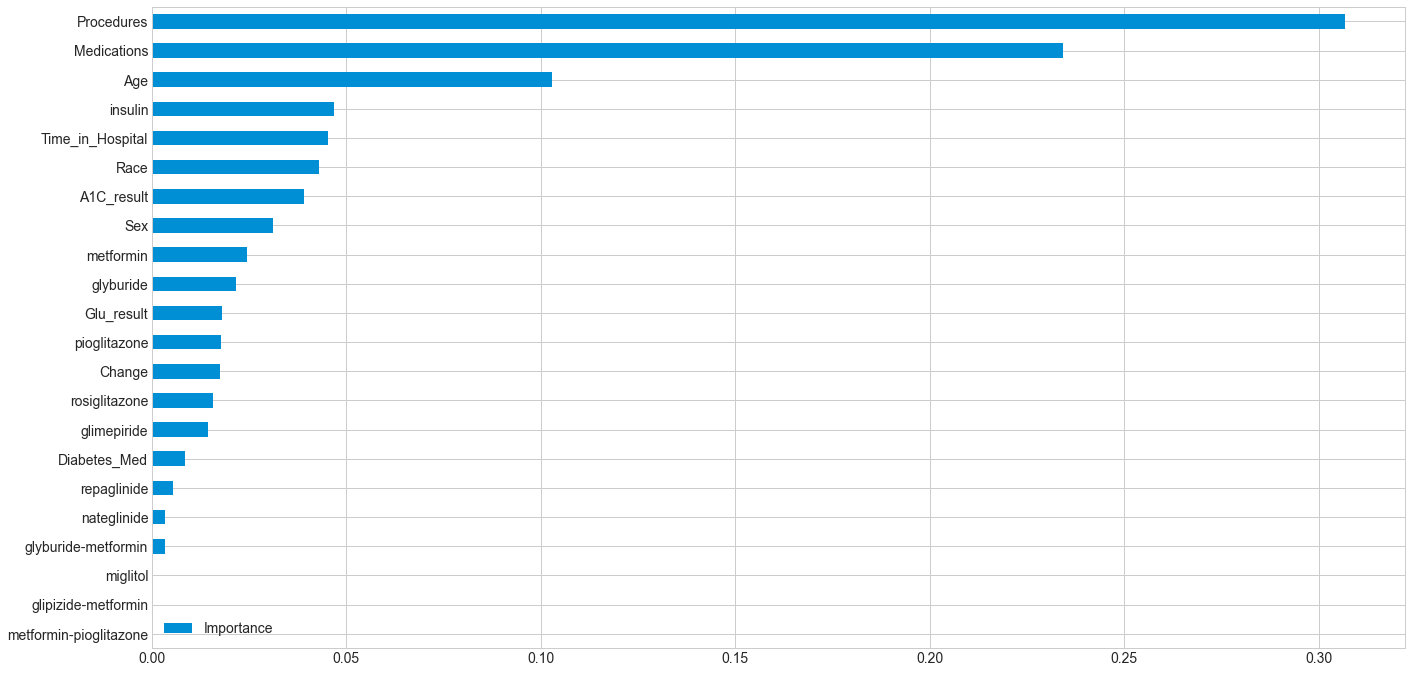

In [9]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(df_con_enc.drop(columns= ['Readmitted','Pmo'], axis=1), df_con_enc['Readmitted'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=df_con_enc.drop(columns= ['Readmitted','Pmo'], axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2))

#### Why would you want feature importance?

Feature importance shows how much each feature contributed to the model.

We could take this information and remove features which don't contribute much to reduce dimenstionality (and save compute).

Feature importance figures also show people who may not be familiar with the problem what features of their data are most important when it comes to making predictions with machine learning models.

## 4. Splitting into Training and Testing datasets.

**We need to split the data into the training and testing datasets.**

There is no optimal split percentage.

> You must choose a split percentage that meets your project’s objectives with considerations that include:
- **Computational cost in training the model.**
- **Computational cost in evaluating the model.**
- **Training set representativeness.**
- **Test set representativeness.**

> Nevertheless, common split percentages include:
- **Train: 80%, Test: 20%**
- **Train: 67%, Test: 33%**
- **Train: 50%, Test: 50%**

In [10]:
# We will be using the Label Encoded dataframe for simplicity.
selected_df = df_con_enc

In [11]:
X = selected_df.drop('Readmitted', axis= 1)
y = selected_df['Readmitted']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify= y)

In [13]:
X_train = X_train.drop('Pmo', axis= 1)
X_train.head()

,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone
3923,2,1,4,0,75,19,2,0,0,1,1,1,1,1,1,1,1,0,2,1,0,0
5407,2,1,5,0,39,8,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
23244,2,0,6,0,0,4,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
3573,0,1,7,0,34,7,2,1,0,1,1,1,1,1,2,1,1,0,1,1,0,0
10259,2,0,4,0,7,14,2,2,1,1,1,1,1,1,1,2,1,0,0,1,0,0


In [14]:
y_train.head(10)

3923     1
5407     0
23244    0
3573     1
10259    1
19123    1
11239    0
14980    1
19892    0
24044    0
Name: Readmitted, dtype: int32

In [15]:
X_test.head()

,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone,Pmo
11283,2,1,3,2,35,11,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,60817248.0
9081,2,1,7,2,42,17,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,24204024.0
281,0,0,5,4,65,27,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,8166528.0
22937,2,1,7,2,56,19,2,1,1,1,2,1,1,1,1,1,1,0,2,1,0,0,50630004.0
3472,2,1,7,2,63,5,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0,79113843.0


## 5. Start Building Maching Learning Models

Before running a ML model our aim was to turn all values to numbers. Since we have done that, we will now run a series of machine learning algorithm to see which will yield the best results.

### Algorithms
From here, we will be running the following algorithms.

- **Logistic Regression**
- **KNN**
- **Naive Bayes**
- **Stochastic Gradient Decent**
- **Linear SVC**
- **Decision Tree**
- **Gradient Boosted Trees**
- **CatBoost Algorithm**

In any model building, we mainly focus on 3 main steps:

- Fitting the model and finding the accuracy (accuracy score) of the fitted model.
- Perform K-Fold Cross Validation (K needs to be specified).
- Find the accuracy of the Cross Validation. 

**We will be running a whole bunch of models to figure out which model is best suited for our data.**

In [16]:
# For our simplicity let us create a function that we can call for each model.
def ML_algo(algo, X_train, y_train, cv):
    
    ## Step 1:
    model = algo.fit(X_train, y_train)                          # Creating the model. We will fit the algorithm to the training data.
    accuracy = round(model.score(X_train, y_train)*100, 2)

    ## Step 2:  --> This code performs Cross Validation automatically.
    train_pred = model_selection.cross_val_predict(algo, X_train, y_train, cv= cv, n_jobs= -1)

    
    ## Step 3:  --> Cross Validation accuracy metric.
    accuracy_cv = round(metrics.accuracy_score(y_train, train_pred)*100, 2)

    return train_pred, accuracy, accuracy_cv

#### Model 1: Logistic Regression

In [17]:
# Logistic Regression
start_time = time.time()
log_train_pred, log_acc, log_acc_cv = ML_algo(LogisticRegression(), X_train, y_train, 10)

log_time = (time.time()- start_time)

print('Accuracy of the model is: ', log_acc)
print('Accuracy of 10-Fold CV is: ', log_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= log_time))

Accuracy of the model is:  60.05
Accuracy of 10-Fold CV is:  60.13
Running time is:  0:00:24.832748


#### Model 2: K-Nearest Neighbours

In [22]:
# K-Nearest Neighbours
start_time = time.time()
knn_train_pred, knn_acc, knn_acc_cv = ML_algo(KNeighborsClassifier(n_neighbors= 7), X_train, y_train, 10)

knn_time = (time.time()- start_time)

print('Accuracy of the model is: ', knn_acc)
print('Accuracy of 10-Fold CV is: ', knn_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= knn_time))

Accuracy of the model is:  68.2
Accuracy of 10-Fold CV is:  55.6
Running time is:  0:00:13.770294


#### Model 3: Gaussian Naive Bayes

In [23]:
# Gaussian Naive Bayes
start_time = time.time()
gnb_train_pred, gnb_acc, gnb_acc_cv = ML_algo(GaussianNB(), X_train, y_train, 10)

gnb_time = (time.time()- start_time)

print('Accuracy of the model is: ', gnb_acc)
print('Accuracy of 10-Fold CV is: ', gnb_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= gnb_time))

Accuracy of the model is:  60.1
Accuracy of 10-Fold CV is:  58.13
Running time is:  0:00:00.896365


#### Model 4: Linear Support Vector Machines (SVC)

In [24]:
# Support Vector Machines
start_time = time.time()
svm_train_pred, svm_acc, svm_acc_cv = ML_algo(LinearSVC(), X_train, y_train, 10)

svm_time = (time.time()- start_time)

print('Accuracy of the model is: ', svm_acc)
print('Accuracy of 10-Fold CV is: ', svm_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= svm_time))

Accuracy of the model is:  58.87
Accuracy of 10-Fold CV is:  50.4
Running time is:  0:01:32.800418


#### Model 5: Stochastic Gradient Descent

In [25]:
# Stochastic Gradient Descent
start_time = time.time()
sgd_train_pred, sgd_acc, sgd_acc_cv = ML_algo(SGDClassifier(), X_train, y_train, 10)

sgd_time = (time.time()- start_time)

print('Accuracy of the model is: ', sgd_acc)
print('Accuracy of 10-Fold CV is: ', sgd_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= sgd_time))

Accuracy of the model is:  42.36
Accuracy of 10-Fold CV is:  51.77
Running time is:  0:00:16.774949


#### Model 6: Decision Tree Classifier

In [26]:
# Decision Tree Classifier
start_time = time.time()
dtc_train_pred, dtc_acc, dtc_acc_cv = ML_algo(DecisionTreeClassifier(), X_train, y_train, 10)

dtc_time = (time.time()- start_time)

print('Accuracy of the model is: ', dtc_acc)
print('Accuracy of 10-Fold CV is: ', dtc_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= dtc_time))

Accuracy of the model is:  99.49
Accuracy of 10-Fold CV is:  53.54
Running time is:  0:00:03.113652


#### Model 7: Gradient Boost Trees

In [27]:
# Gradient Boost Trees
start_time = time.time()
gbt_train_pred, gbt_acc, gbt_acc_cv = ML_algo(GradientBoostingClassifier(), X_train, y_train, 10)

gbt_time = (time.time()- start_time)

print('Accuracy of the model is: ', gbt_acc)
print('Accuracy of 10-Fold CV is: ', gbt_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= gbt_time))

Accuracy of the model is:  62.33
Accuracy of 10-Fold CV is:  60.58
Running time is:  0:00:50.125006


#### Model 8: CatBoost Algorithm

This is by a Russian company (Yandex) who created it as an in-house algorithm but now it is open sourced.

- CatBoost is a state-of-the-art open source gradient boosting on decision trees library.
- It is simple and easy to use. 

For more details --> https://catboost.ai/

In [28]:
# View the features for CatBoost model
X_train.head()

,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone
3923,2,1,4,0,75,19,2,0,0,1,1,1,1,1,1,1,1,0,2,1,0,0
5407,2,1,5,0,39,8,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
23244,2,0,6,0,0,4,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
3573,0,1,7,0,34,7,2,1,0,1,1,1,1,1,2,1,1,0,1,1,0,0
10259,2,0,4,0,7,14,2,2,1,1,1,1,1,1,1,2,1,0,0,1,0,0


In [29]:
# View the label for CatBoost model
y_train.head()

3923     1
5407     0
23244    0
3573     1
10259    1
Name: Readmitted, dtype: int32

In [30]:
# Define the categorical features for CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21], dtype=int64)

- Therefore, we can see that all the features are integers.

In [31]:
# We will use CatBoost Pool() function to pool together the training data and the categorical labels
train_pool = Pool(X_train, y_train, cat_features)

In [32]:
# CatBoost Model definition
catboost_model = CatBoostClassifier(iterations= 1000, custom_loss= ['Accuracy'], loss_function= 'Logloss')

# Fit CatBoost model
catboost_model.fit(train_pool, plot= False)

# CatBoost accuracy
catboost_acc = round(catboost_model.score(X_train, y_train)*100, 2)

earn: 0.6286866	total: 4m 54s	remaining: 2m 56s
625:	learn: 0.6285922	total: 4m 54s	remaining: 2m 55s
626:	learn: 0.6285505	total: 4m 54s	remaining: 2m 55s
627:	learn: 0.6285188	total: 4m 55s	remaining: 2m 54s
628:	learn: 0.6284722	total: 4m 55s	remaining: 2m 54s
629:	learn: 0.6284180	total: 4m 56s	remaining: 2m 53s
630:	learn: 0.6283938	total: 4m 56s	remaining: 2m 53s
631:	learn: 0.6283215	total: 4m 56s	remaining: 2m 52s
632:	learn: 0.6283075	total: 4m 57s	remaining: 2m 52s
633:	learn: 0.6282582	total: 4m 57s	remaining: 2m 51s
634:	learn: 0.6282331	total: 4m 58s	remaining: 2m 51s
635:	learn: 0.6281918	total: 4m 59s	remaining: 2m 51s
636:	learn: 0.6281053	total: 4m 59s	remaining: 2m 50s
637:	learn: 0.6280519	total: 5m	remaining: 2m 50s
638:	learn: 0.6280245	total: 5m 1s	remaining: 2m 50s
639:	learn: 0.6279539	total: 5m 1s	remaining: 2m 49s
640:	learn: 0.6278924	total: 5m 2s	remaining: 2m 49s
641:	learn: 0.6278571	total: 5m 2s	remaining: 2m 48s
642:	learn: 0.6277985	total: 5m 3s	remaini

In [33]:
# CatBoost Cross Validation
start_time = time.time()

# Set the parameters for cross validation as same as the initial model
cv_param = catboost_model.get_params()

# Run 10-Folds CV
cv_data = cv(train_pool, cv_param, fold_count= 10, plot= False)

# How long does it take?
catboost_time = (time.time()- start_time)

# CatBoost results get saved into a dataframe,the maximum accuracy score is
catboost_acc_cv = round(np.max(cv_data['test-Accuracy-mean'])*100, 2)

8 (576)	total: 46m 16s	remaining: 12m 40s
785:	learn: 0.6247161	test: 0.6607468	best: 0.6604918 (576)	total: 46m 20s	remaining: 12m 37s
786:	learn: 0.6246836	test: 0.6607430	best: 0.6604918 (576)	total: 46m 24s	remaining: 12m 33s
787:	learn: 0.6246360	test: 0.6607334	best: 0.6604918 (576)	total: 46m 29s	remaining: 12m 30s
788:	learn: 0.6245978	test: 0.6607236	best: 0.6604918 (576)	total: 46m 33s	remaining: 12m 27s
789:	learn: 0.6245622	test: 0.6607228	best: 0.6604918 (576)	total: 46m 38s	remaining: 12m 23s
790:	learn: 0.6245193	test: 0.6607295	best: 0.6604918 (576)	total: 46m 42s	remaining: 12m 20s
791:	learn: 0.6244900	test: 0.6607332	best: 0.6604918 (576)	total: 46m 46s	remaining: 12m 17s
792:	learn: 0.6244605	test: 0.6607295	best: 0.6604918 (576)	total: 46m 50s	remaining: 12m 13s
793:	learn: 0.6244076	test: 0.6607295	best: 0.6604918 (576)	total: 46m 55s	remaining: 12m 10s
794:	learn: 0.6243811	test: 0.6607438	best: 0.6604918 (576)	total: 46m 59s	remaining: 12m 7s
795:	learn: 0.62434

In [34]:
# CatBoost Algorithm
print('Accuracy of the model is: ', catboost_acc)
print('Accuracy of 10-Fold CV is: ', catboost_acc_cv)
print('Running time is: ', datetime.timedelta(seconds= catboost_time))

Accuracy of the model is:  62.58
Accuracy of 10-Fold CV is:  60.61
Running time is:  1:01:46.314972


### Model Results

Now let's see which model has the best cross-validation accuracy.

- <b>NOTE:</b> We care more about the accuracy of cross validation, as the metrics we get from the model can randomly score higher than usual.

In [35]:
cv_models = pd.DataFrame({'Model':[' Logistic Regression', 'K-Nearest Neighbours', 'Gaussian Naive Bayes', 
                                'Linear Support Vector Machines (SVC)', 'Stochastic Gradient Descent', 
                                'Decision Tree Classifier', 'Gradient Boost Trees', 'CatBoost Algorithm'],
                      'Score':[log_acc_cv, knn_acc_cv, gnb_acc_cv, svm_acc_cv, sgd_acc_cv, dtc_acc_cv,gbt_acc_cv,        
                               catboost_acc_cv]})

print('-----Cross-Validation Accuracy Scores-----')
cv_models.nlargest(8,'Score')

-----Cross-Validation Accuracy Scores-----


,Model,Score
7,CatBoost Algorithm,60.61
6,Gradient Boost Trees,60.58
0,Logistic Regression,60.13
2,Gaussian Naive Bayes,58.13
1,K-Nearest Neighbours,55.60
5,Decision Tree Classifier,53.54
4,Stochastic Gradient Descent,51.77
3,Linear Support Vector Machines (SVC),50.40


> We can see that CatBoost model have the best result. Since guessing would give us 50% accuracy (0 or 1), getting above 60% is good. It can also be seen that both Gradient Boost Trees and Logistic Regression are not far behind.

- Cross Validation is more robust than the .fit() model as it does multiple passes over the data instead of one.

## 7. Precision and Recall

Precision and Recall are metrics that you use when you have an imbalanced classification problem.

- Recall - a metric which measures a models ability to find all relevant cases in a dataset.
- Precision - a metric which measures a models ability to correctly identify only relevant cases.

Combining  Precision and Recall gives us the **F1 score.**

They fall between 0 and 1, with 1 being better.

In [36]:
# For CatBoost Model
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool, metrics= metrics, plot= False)

for metric in metrics:
    print(str(metric)+ ': {}' .format(np.mean(eval_metrics[metric])))

Precision: 0.60320244345282
Recall: 0.1514155056759546
F1: 0.2387951458908928
AUC: 0.6282061031145783


> **Recall = TP/(TP + FN)**
- Here the Recall is pretty low. This means that there is a higher amount of False Negatives (predicting 'Not Readmitted' when it is actually 'Readmitted').

> **Pression = TP/(TP + FP)**
- Precision is high. Thus, we can say say that there is less false positives (predicting 'Readmitted' when it is actually 'Not Readmitted')

## 6. Prediction on the Test dataset

Let's use the model with the highest cross-validation accuracy score to make a prediction on the test dataset.

We want to make predictions on the same columnns our model is trained on.

So we have to select the subset of right columns of the test dateframe, encode them and make a prediciton with our model.

In [37]:
X_train.head()

,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone
3923,2,1,4,0,75,19,2,0,0,1,1,1,1,1,1,1,1,0,2,1,0,0
5407,2,1,5,0,39,8,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
23244,2,0,6,0,0,4,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0
3573,0,1,7,0,34,7,2,1,0,1,1,1,1,1,2,1,1,0,1,1,0,0
10259,2,0,4,0,7,14,2,2,1,1,1,1,1,1,1,2,1,0,0,1,0,0


In [38]:
X_test.head()

,Race,Sex,Age,Time_in_Hospital,Procedures,Medications,Glu_result,A1C_result,Change,Diabetes_Med,metformin,repaglinide,nateglinide,glimepiride,glyburide,pioglitazone,rosiglitazone,miglitol,insulin,glyburide-metformin,glipizide-metformin,metformin-pioglitazone,Pmo
11283,2,1,3,2,35,11,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,60817248.0
9081,2,1,7,2,42,17,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,24204024.0
281,0,0,5,4,65,27,2,2,0,1,1,1,1,1,1,1,1,0,2,1,0,0,8166528.0
22937,2,1,7,2,56,19,2,1,1,1,2,1,1,1,1,1,1,0,2,1,0,0,50630004.0
3472,2,1,7,2,63,5,2,2,0,0,1,1,1,1,1,1,1,0,1,1,0,0,79113843.0


In [39]:
# Create a list of columns to be used for predictions.
wanted_columns = X_train.columns
wanted_columns

Index(['Race', 'Sex', 'Age', 'Time_in_Hospital', 'Procedures', 'Medications',
       'Glu_result', 'A1C_result', 'Change', 'Diabetes_Med', 'metformin',
       'repaglinide', 'nateglinide', 'glimepiride', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'miglitol', 'insulin',
       'glyburide-metformin', 'glipizide-metformin', 'metformin-pioglitazone'],
      dtype='object')

In [40]:
# Make predictions using CatBoost model on wanted columns.
predictions = catboost_model.predict(X_test[wanted_columns].apply(LabelEncoder().fit_transform))

In [41]:
# Our predictions array is comprised of 1's and 0's (Readmitted or Not Readmitted).
predictions[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [42]:
# Create a dataframe and append the relevant colimns.
final = pd.DataFrame()
final['Patient Number'] = X_test['Pmo']
final['Actual'] = y_test
final['Readmitted'] = predictions
final.head(10)

,Patient Number,Actual,Readmitted
11283,60817248.0,0,0
9081,24204024.0,0,0
281,8166528.0,0,0
22937,50630004.0,0,0
3472,79113843.0,0,0
13227,84554370.0,1,0
17252,60108309.0,0,0
20386,42052068.0,0,0
95,1753524.0,0,0
19894,43296480.0,0,1


In [43]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, predictions)
print('Accuracy: %.3f' % acc)

Accuracy: 0.601


- Since CatBoost Model has a higher test prediction accuracy, we will be choosing the results of this model.